In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
def load_all_batches(source_folder, num_batches):
    all_images = []
    all_labels = []
    for i in range(num_batches):
        image_path = os.path.join(source_folder, f'processed_images_batch_{i}.npy')
        label_path = os.path.join(source_folder, f'processed_labels_batch_{i}.npy')
        if not os.path.exists(image_path) or not os.path.exists(label_path):
            print(f"Batch {i} not found, skipping.")
            continue
        images = np.load(image_path)
        labels = np.load(label_path)
        all_images.append(images)
        all_labels.append(labels)
    X = np.concatenate(all_images, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

# Set the folder path and number of batches (adjust as needed)
data_folder = '/Users/issackondreddy/Desktop/Programming/ML Project/Lung Cancer Detection/data/processed_images_by_filter'
num_batches = 10  # Update this number based on your data

X, y = load_all_batches(data_folder, num_batches)
print("Loaded data shapes:", X.shape, y.shape)


Loaded data shapes: (160, 224, 224) (160,)


In [3]:
target_size = (224, 224)

def preprocess_images(images):
    processed = []
    for img in images:
        # If image is grayscale (2D) or has a single channel, convert to 3 channels.
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img = np.concatenate([img] * 3, axis=-1)
        # Resize image
        img_resized = tf.image.resize(img, target_size).numpy()
        processed.append(img_resized)
    processed = np.array(processed)
    # Normalize pixel values to [0, 1]
    processed = processed.astype(np.float32) / 255.0
    # Apply DenseNet preprocessing (scaling and mean subtraction as required)
    processed = preprocess_input(processed)
    return processed

X_processed = preprocess_images(X)
print("Processed images shape:", X_processed.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Processed images shape: (160, 224, 224, 3)
Training set: (128, 224, 224, 3) (128,)
Validation set: (32, 224, 224, 3) (32,)


In [4]:
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

# Load DenseNet121 base model without the top layers and with global average pooling.
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Number of classes: 3
29084464/29084464 [==============================] - 25s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None,

In [5]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
4/4 [==============================] - 7s 2s/step - loss: 1.1069 - accuracy: 0.3672 - val_loss: 1.0824 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 1.0971 - accuracy: 0.3672 - val_loss: 1.0798 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 4s 996ms/step - loss: 1.0947 - accuracy: 0.3828 - val_loss: 1.0784 - val_accuracy: 0.4688
Epoch 4/20
4/4 [==============================] - 4s 1s/step - loss: 1.0958 - accuracy: 0.3672 - val_loss: 1.0782 - val_accuracy: 0.3750
Epoch 5/20
4/4 [==============================] - 4s 999ms/step - loss: 1.0926 - accuracy: 0.3672 - val_loss: 1.0707 - val_accuracy: 0.5312
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 1.0920 - accuracy: 0.4453 - val_loss: 1.0808 - val_accuracy: 0.4375
Epoch 7/20
4/4 [==============================] - 4s 996ms/step - loss: 1.0904 - accuracy: 0.3906 - val_loss: 1.0841 - val_accuracy: 0.4688
Epoch 8/20
4/4 [================

1/1 [==============================] - 1s 763ms/step - loss: 1.0429 - accuracy: 0.5000
Validation Loss: 1.0428893566131592 Validation Accuracy: 0.5


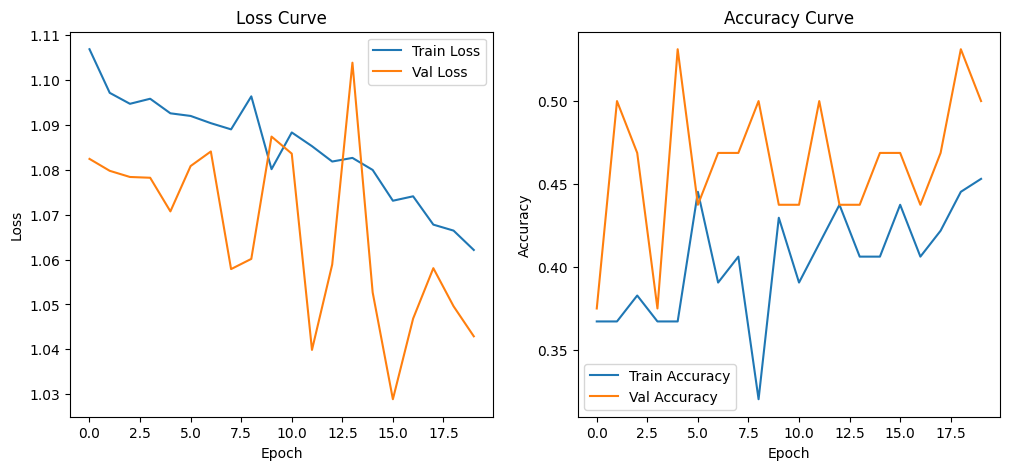

In [6]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss, "Validation Accuracy:", val_accuracy)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()